In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from src.OED import *
from src.DQN import *
from src.GA import *
from pde.AdvectionDiffusionReaction import *

In [4]:
adr_config = ADRConfig()
adr_eq = ADR(adr_config)

## DQN

In [5]:
seed = None
gym_config = OEDGymConfig()
gym_config.n_sensor = 5

gym_config.n_components_rewards = 5

### Old action space

In [6]:
gym_config.old_action_space = True

In [7]:
adr_dqn_old_a = DQN_OED(seed, pde_system=adr_eq, gym_config=gym_config, verbose=1)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
model_name = "adr_dqn_old_a_1"
adr_dqn_old_a.train(model_name, total_timesteps=50000, log_interval=10)

Logging to ./tensorboard/DQN_19


In [ ]:
old_a_all_ep_rewards, old_a_best_rewards, old_a_optimal_states_all = adr_dqn_old_a.evaluate(num_episodes=100)

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(old_a_best_rewards, bins=20, color='skyblue', edgecolor='black', alpha=0.75)
plt.xlabel('Episode Best Reward')
plt.ylabel('Frequency')
plt.title('Distradrution of Episode Best Rewards')
plt.grid(True)
plt.show()


In [ ]:
# Compute sum of optimal_states over all episodes
# Assumes that each info["optimal_states"] is a numpy array of the same shape
optimal_states_stack = np.array(old_a_optimal_states_all)
mean_optimal_states = np.sum(optimal_states_stack, axis=0)

# Plot grid of mean optimal_states
plt.figure(figsize=(8, 6))
plt.imshow(mean_optimal_states, cmap='viridis', interpolation='nearest')
plt.title('Total placements in optimal States over Episodes')
plt.colorbar(label='Total placements')
plt.xlabel('Grid X')
plt.ylabel('Grid Y')
plt.show()

### New Action Space

In [ ]:
gym_config.old_action_space = False

In [ ]:
adr_dqn_new_a = DQN_OED(seed, pde_system=adr_eq, gym_config=gym_config, verbose=1)

In [ ]:
model_name = "adr_dqn_new_a_1"
adr_dqn_new_a.train(model_name, total_timesteps=50000, log_interval=10)

In [ ]:
new_a_all_ep_rewards, new_a_best_rewards, new_a_optimal_states_all = adr_dqn_new_a.evaluate(num_episodes=100)

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(new_a_best_rewards, bins=20, color='skyblue', edgecolor='black', alpha=0.75)
plt.xlabel('Episode Best Reward')
plt.ylabel('Frequency')
plt.title('Distradrution of Episode Best Rewards')
plt.grid(True)
plt.show()

In [ ]:
# Compute sum of optimal_states over all episodes
# Assumes that each info["optimal_states"] is a numpy array of the same shape
optimal_states_stack = np.array(new_a_optimal_states_all)
mean_optimal_states = np.sum(optimal_states_stack, axis=0)

# Plot grid of mean optimal_states
plt.figure(figsize=(8, 6))
plt.imshow(mean_optimal_states, cmap='viridis', interpolation='nearest')
plt.title('Total placements in optimal States over Episodes')
plt.colorbar(label='Total placements')
plt.xlabel('Grid X')
plt.ylabel('Grid Y')
plt.show()

## GA

In [ ]:
ga_config = GAConfig()

In [ ]:
ga_config.generations = 5000

In [ ]:
ga = GA_OED(seed, pde_system=adr_eq, gym_config=gym_config, ga_config=ga_config)

In [ ]:
best_individual, best_fitness, sensor_positions, logbook = ga.run()

In [ ]:
print(f"Best fitness: {best_fitness}")
print(f"Sensor positions: {sensor_positions}")

In [ ]:
# Visualize the solution
# ga.visualize_solution(sensor_positions)

# Plot evolution progress
gen = logbook.select("gen")
fit_max = logbook.select("max")
fit_avg = logbook.select("avg")

plt.figure(figsize=(10, 6))
plt.plot(gen, fit_max, 'b-', label='Maximum Fitness')
plt.plot(gen, fit_avg, 'r-', label='Average Fitness')
plt.title('Evolution of Coverage')
plt.xlabel('Generation')
plt.ylabel('Coverage Percentage')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Compute sum of optimal_states over all episodes
# Assumes that each info["optimal_states"] is a numpy array of the same shape
mean_optimal_states =np.zeros((ga.env.nx, ga.env.ny))
mean_optimal_states[37, 19] = 1
mean_optimal_states[46, 14] = 1

# Plot grid of mean optimal_states
plt.figure(figsize=(8, 6))
plt.imshow(mean_optimal_states, cmap='viridis', interpolation='nearest')
plt.title('Total placements in optimal States over Episodes')
plt.colorbar(label='Total placements')
plt.xlabel('Grid X')
plt.ylabel('Grid Y')
plt.show()

## Plots

In [ ]:
env = adr_dqn_old_a.env

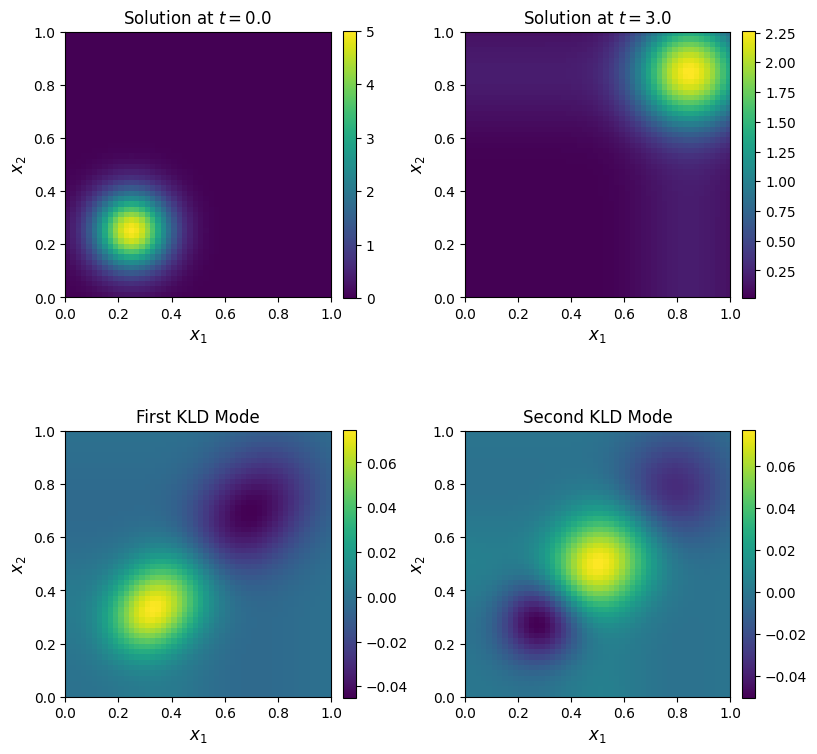

In [43]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

im1 = axes[0, 0].imshow(env.pde_field[:, :, 0].T, origin='lower', extent=[0, 1, 0, 1])
axes[0, 0].set_title(rf"Solution at $t = {env.pde_system.t_steps[0]}$", fontsize=12)
axes[0, 0].set_xlabel(r'$x_1$', fontsize=12)
axes[0, 0].set_ylabel(r'$x_2$', fontsize=12)
cbar1 = fig.colorbar(im1, ax=axes[0, 0], fraction=0.046, pad=0.04)
cbar1.ax.tick_params(labelsize=10)

# Second subplot
im2 = axes[0, 1].imshow(env.pde_field[:, :, -1].T, origin='lower', extent=[0, 1, 0, 1])
axes[0, 1].set_title(rf"Solution at $t = {env.pde_system.t_steps[-1]}$", fontsize=12)
axes[0, 1].set_xlabel(r'$x_1$', fontsize=12)
axes[0, 1].set_ylabel(r'$x_2$', fontsize=12)
cbar2 = fig.colorbar(im2, ax=axes[0, 1], fraction=0.046, pad=0.04)
cbar2.ax.tick_params(labelsize=10)

# Third subplot
im3 = axes[1, 0].imshow(env.modes[:, 0].reshape(env.nx, env.ny).T, origin='lower', extent=[0, 1, 0, 1])
axes[1, 0].set_title(rf"First KLD Mode", fontsize=12)
axes[1, 0].set_xlabel(r'$x_1$', fontsize=12)
axes[1, 0].set_ylabel(r'$x_2$', fontsize=12)
cbar3 = fig.colorbar(im3, ax=axes[1, 0], fraction=0.046, pad=0.04)
cbar3.ax.tick_params(labelsize=10)

# Fourth subplot
im4 = axes[1, 1].imshow(env.modes[:, 1].reshape(env.nx, env.ny), origin='lower', extent=[0, 1, 0, 1])
axes[1, 1].set_title(rf"Second KLD Mode", fontsize=12)
axes[1, 1].set_xlabel(r'$x_1$', fontsize=12)
axes[1, 1].set_ylabel(r'$x_2$', fontsize=12)
cbar4 = fig.colorbar(im4, ax=axes[1, 1], fraction=0.046, pad=0.04)
cbar4.ax.tick_params(labelsize=10)

# Adjust layout to avoid overlap
plt.tight_layout(pad=0.1)
# plt.savefig("adr2dSol.pdf", dpi=400)

# Show the plot
plt.show()


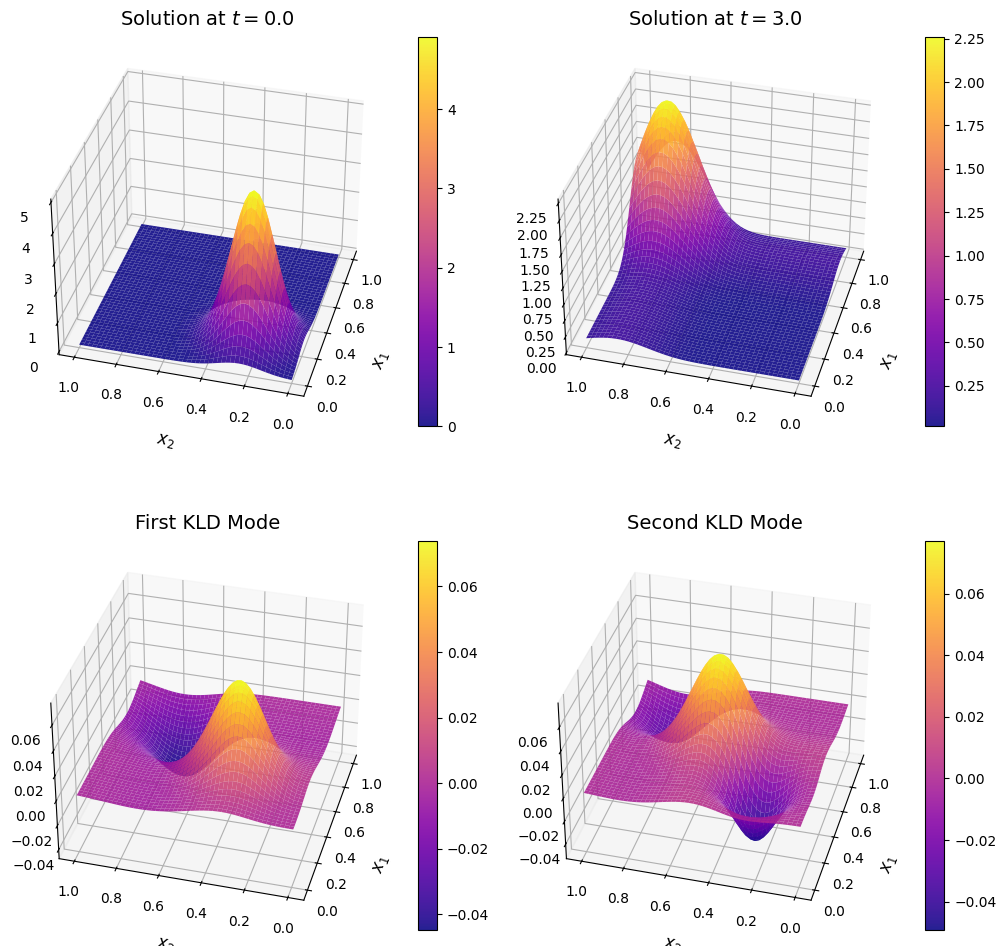

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import LightSource

# Create a 2x2 grid of 3D subplots
fig = plt.figure(figsize=(12, 12))  # Increase size for better visadrility

# Generate grid points
x = np.linspace(0, 1, env.nx)
y = np.linspace(0, 1, env.ny)
X, Y = np.meshgrid(x, y)

# Define the plots
datasets = [
    (env.pde_field[:, :, 0].T, rf"Solution at $t = {env.pde_system.t_steps[0]}$"),
    (env.pde_field[:, :, -1].T, rf"Solution at $t = {env.pde_system.t_steps[-1]}$"),
    (env.modes[:, 0].reshape(env.nx, env.ny).T, "First KLD Mode"),
    (env.modes[:, 1].reshape(env.nx, env.ny).T, "Second KLD Mode")
]

# Create 3D subplots
for i, (data, title) in enumerate(datasets):
    ax = fig.add_subplot(2, 2, i + 1, projection='3d')
    
    # Compute shading effect
    ls = LightSource(azdeg=115, altdeg=65)
    shaded = ls.shade(data, cmap=cm.coolwarm, vert_exag=0.1, blend_mode='soft')

    # Create surface plot
    surf = ax.plot_surface(X, Y, data, cmap='plasma', edgecolor='none', alpha=0.9)
    
    # Set titles and labels
    ax.set_title(title, fontsize=14, pad=10)
    ax.set_xlabel(r'$x_1$', fontsize=12, labelpad=10)
    ax.set_ylabel(r'$x_2$', fontsize=12, labelpad=10)
    # ax.set_zlabel(r'$u(x_1, x_2)$', fontsize=12, labelpad=10)

    # Adjust viewing angle
    ax.view_init(elev=35, azim=-165)

    # Add colorbar
    fig.colorbar(surf, ax=ax, fraction=0.046, pad=0.04)

# Adjust layout
# plt.tight_layout()
# plt.savefig("3D_Poster_Plot.pdf", dpi=400, bbox_inches='tight')

# Show the plot
plt.show()


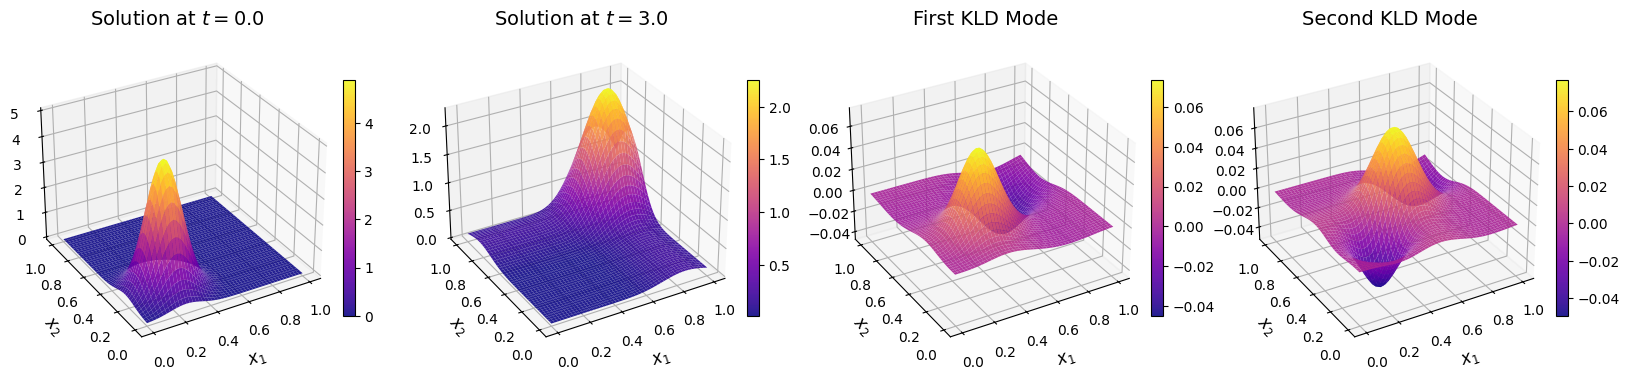

In [25]:
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib import cm
# from matplotlib.colors import LightSource

# # Create a 1x4 grid of 3D subplots
# fig = plt.figure(figsize=(20, 6))  # Wider figure for 1x4 layout

# # Generate grid points
# x = np.linspace(0, 1, env.nx)
# y = np.linspace(0, 1, env.ny)
# X, Y = np.meshgrid(x, y)

# # Define the plots
# datasets = [
#     (env.pde_field[:, :, 0].T, rf"Solution at $t = {env.pde_system.t_steps[0]}$"),
#     (env.pde_field[:, :, -1].T, rf"Solution at $t = {env.pde_system.t_steps[-1]}$"),
#     (env.modes[:, 0].reshape(env.nx, env.ny).T, "First KLD Mode"),
#     (env.modes[:, 1].reshape(env.nx, env.ny).T, "Second KLD Mode")
# ]

# # Create 3D subplots in a single row
# for i, (data, title) in enumerate(datasets):
#     ax = fig.add_subplot(1, 4, i + 1, projection='3d')
    
#     # Compute shading effect
#     ls = LightSource(azdeg=315, altdeg=65)
#     shaded = ls.shade(data, cmap=cm.coolwarm, vert_exag=0.1, blend_mode='soft')

#     # Create surface plot
#     surf = ax.plot_surface(X, Y, data, cmap='plasma', edgecolor='none', alpha=0.9)
    
#     # Set titles and labels
#     ax.set_title(title, fontsize=14, pad=10)
#     ax.set_xlabel(r'$x_1$', fontsize=12, labelpad=5)
#     ax.set_ylabel(r'$x_2$', fontsize=12, labelpad=5)
    
#     # Adjust viewing angle
#     ax.view_init(elev=30, azim=-120)

#     # Add colorbar (adjusted for compact layout)
#     fig.colorbar(surf, ax=ax, fraction=0.035, pad=0.02)

# # Save and display
# plt.savefig("3D_adr2d_modes.pdf", dpi=400, bbox_inches='tight')
# plt.show()


In [27]:
print(f"{np.max(old_a_best_rewards):.3e}, {np.max(new_a_best_rewards):.3e}, {best_fitness:.3e}, {np.mean(old_a_best_rewards):.3e}, {np.mean(new_a_best_rewards):.3e}")

3.508e-05, 5.385e-04, 9.916e-01, 7.041e-07, 9.933e-06
